In [36]:
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import random
import time
import shap
import os
import gc


from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive

from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from collections import defaultdict
from inspect import signature

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import warnings
# warning.filterwarning('ignore')

In [ ]:
# from sklearn.metrics import average_precision_score


## load dev data

In [2]:
# df_dev = pd.read_pickle('../data/df_dev.pkl')
# df_dev.shape

(18248533, 81)

In [4]:
conn = hive_connection('dmig')
sql = 'select * from comm.user_input_matrix_for_upsell_monthly'
df_input_01 = load_from_hive(conn, sql)

2019-07-02 12:53:18,561 - YE_HIVE - INFO - ...tmp_db name = tmp_20190702_12_53_18_9a39f6f5c852748feb4aa9215c858cab7486f90c
2019-07-02 12:53:18,563 - YE_HIVE - INFO - Start creating table
2019-07-02 12:53:18,564 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190702_12_53_18_9a39f6f5c852748feb4aa9215c858cab7486f90c
2019-07-02 12:53:18,608 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190702_12_53_18_9a39f6f5c852748feb4aa9215c858cab7486f90c' is done
2019-07-02 12:54:39,473 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190702_12_53_18_9a39f6f5c852748feb4aa9215c858cab7486f90c 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from comm.user_input_matrix_for_upsell_monthly' is done
2019-07-02 12:54:39,826 - YE_HIVE - INFO - Elapsed Time = 81.26
2019-07-02 12:54:39,827 - YE_HIVE

In [5]:
df_input_01.to_pickle('../data/input_01.pkl')

In [11]:
conn = hive_connection('dmig')
sql = "select * from comm.user_label_matrix_for_upsell_monthly where ym='201902'"
df_label_02 = load_from_hive(conn, sql)

2019-07-02 13:08:03,340 - YE_HIVE - INFO - ...tmp_db name = tmp_20190702_13_08_03_6cc44c45fbc0b73c8a9818c0fb40b71135950418
2019-07-02 13:08:03,342 - YE_HIVE - INFO - Start creating table
2019-07-02 13:08:03,344 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190702_13_08_03_6cc44c45fbc0b73c8a9818c0fb40b71135950418
2019-07-02 13:08:03,393 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190702_13_08_03_6cc44c45fbc0b73c8a9818c0fb40b71135950418' is done
2019-07-02 13:09:08,077 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190702_13_08_03_6cc44c45fbc0b73c8a9818c0fb40b71135950418 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from comm.user_label_matrix_for_upsell_monthly where ym='201902'' is done
2019-07-02 13:09:08,419 - YE_HIVE - INFO - Elapsed Time = 65.08
2019-07-02 13:0

In [12]:
df_label_02.to_pickle('../data/label_02.pkl')

In [13]:
df_input_01.shape, df_label_02.shape

((18177416, 82), (18804374, 4))

In [8]:
df_input_01 = pd.read_pickle('../data/input_01.pkl')
df_label_02 = pd.read_pickle('../data/label_02.pkl')

df_input_01.shape, df_label_02.shape

((18177416, 82), (18804374, 4))

In [9]:
df_dev = pd.merge(df_input_01, df_label_02[['svc_mgmt_num', 'label']], how='left', on='svc_mgmt_num')

df_dev.shape

(18177416, 83)

In [10]:
df_meta = pd.read_csv('../data/column_meta.csv')

df_meta.head()

source                       dimension  \
0  td_zord_svc_prod, td_zprd_prod  additional_svc_cnt_family_comb   
1  td_zord_svc_prod, td_zprd_prod          additional_svc_cnt_flo   
2  td_zord_svc_prod, td_zprd_prod    additional_svc_cnt_insurance   
3  td_zord_svc_prod, td_zprd_prod        additional_svc_cnt_music   
4  td_zord_svc_prod, td_zprd_prod       additional_svc_cnt_oksusu   

                  desc  etc  
0  가족결합 관련 가입 부가서비스 갯수  NaN  
1      FLO 가입 부가서비스 갯수  NaN  
2   핸드폰 보험 가입 부가서비스 갯수  NaN  
3   FLO 외  가입 부가서비스 갯수  NaN  
4   옥수수 관련 가입 부가서비스 갯수  NaN

## Check data

In [28]:
df_dev.select_dtypes(include=['object']).columns

Index(['svc_mgmt_num', 'nm_cust_num', 'channel', 'ym', 'label'], dtype='object')

In [19]:
dev_col_null_sum = df_dev.isnull().sum()

# null이 있는 cols
print('dev: ', dev_col_null_sum[dev_col_null_sum>0])

dev:  channel    10833
label       1201
dtype: int64


In [20]:
for col in df_dev.select_dtypes(include=['int', 'float']).columns:
    zero_rate = df_dev[df_dev[col]==0].shape[0] /df_dev.shape[0]
    if zero_rate > 0.95:
        print('-'*20)
        print('col: ', col)
        print('zero_rate: ',zero_rate)
        print('')

--------------------
col:  ref_data_usage_in_gb_bf_m0
zero_rate:  0.9578129256655622

--------------------
col:  ref_data_usage_in_gb_bf_m1
zero_rate:  1.0



In [22]:
for col in df_dev.select_dtypes(include=['int', 'float']).columns:
    if df_dev[col].nunique() == 1:
        print('-'*20)
        print('col: ', col)
        print('value: ', df_dev[col].unique())
        print('')

--------------------
col:  ref_data_usage_in_gb_bf_m1
value:  [0.]



***

***

## Preprocess

In [11]:
# channel fillNA
df_dev.channel.fillna('NAN', inplace=True)

# label값 없는 row delete
df_dev = df_dev[df_dev.label.notnull()]

# 필요없는 column delete
df_dev = df_dev.drop(['nm_cust_num', 'ym'], axis=1)

df_dev.shape

(18176215, 81)

In [12]:
# label encodinng

d = defaultdict(LabelEncoder)

cat_cols = ['channel', 'label']
df_dev[cat_cols] = df_dev[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

df_dev[cat_cols].head(), d['channel'].classes_, d['label'].classes_

(   channel  label
 0        3      0
 1        3      0
 2        3      0
 3        3      0
 4        1      0,
 array(['NAN', 'T월드', '고객센터', '오프라인'], dtype=object),
 array(['N', 'Y'], dtype=object))

In [13]:
df_dev.shape

(18176215, 81)

In [108]:
df_dev.to_pickle('../data/df_dev_01.pkl')

***

***

In [20]:
from sm_utils import sampling, evaluate, score_distribution_plot

## sampling ratio (20%)

In [22]:
def sampling(df, label_col, label_ratio=0.2):
    print('label_ratio: ', label_ratio)
    df_tmp = df.copy()
    target_idx = list(df_tmp[df_tmp[label_col]==1].index)
    sample_cnt = round(1/label_ratio) * len(target_idx)
    print('sample_cnt: ', sample_cnt)
    random_idx = random.sample(list(df_tmp[df_tmp[label_col]==0].index), sample_cnt)
    sample_idx = random_idx + target_idx
    
    return df_tmp.loc[sample_idx,:]

In [23]:
df_sample = sampling(df_dev, 'label')

label_ratio:  0.2
sample_cnt:  1680565


In [109]:
# df_sample.to_pickle('../data/df_sample_01.pkl')

In [24]:
idx_col = 'svc_mgmt_num'
target_col = 'label'

feature_cols = [col for col in df_dev.columns if col not in ['svc_mgmt_num', 'label']]

In [25]:
sample_idx_dev = df_sample[[idx_col]]
sample_x_dev = df_sample[feature_cols]
sample_y_dev = df_sample[[target_col]]

sample_x_trn, sample_x_val, sample_y_trn, sample_y_val = train_test_split(sample_x_dev, sample_y_dev, stratify=sample_y_dev, test_size=0.2, random_state=23)

sample_x_trn.shape, sample_x_val.shape,sample_y_trn.shape, sample_y_val.shape

((1613342, 79), (403336, 79), (1613342, 1), (403336, 1))

In [26]:
sample_y_trn.label.sum()/sample_y_trn.shape[0], sample_y_val.label.sum()/sample_y_val.shape[0]

(0.1666664600562063, 0.16666749310748358)

## modeling

In [27]:
lgb_trn = lgb.Dataset(sample_x_trn, sample_y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(sample_x_val, sample_y_val, feature_name=feature_cols)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 30,
}

In [28]:
evals_result = {}
clf = lgb.train(params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=1000,
                early_stopping_rounds=100,
                verbose_eval=50)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.876253	valid_1's auc: 0.876279
[100]	training's auc: 0.900751	valid_1's auc: 0.900804
[150]	training's auc: 0.913807	valid_1's auc: 0.91382
[200]	training's auc: 0.923098	valid_1's auc: 0.923044
[250]	training's auc: 0.928648	valid_1's auc: 0.928501
[300]	training's auc: 0.932315	valid_1's auc: 0.932062
[350]	training's auc: 0.935815	valid_1's auc: 0.935418
[400]	training's auc: 0.939074	valid_1's auc: 0.938518
[450]	training's auc: 0.941102	valid_1's auc: 0.940392
[500]	training's auc: 0.943532	valid_1's auc: 0.942668
[550]	training's auc: 0.944946	valid_1's auc: 0.943905
[600]	training's auc: 0.946278	valid_1's auc: 0.94507
[650]	training's auc: 0.947221	valid_1's auc: 0.945823
[700]	training's auc: 0.948474	valid_1's auc: 0.946923
[750]	training's auc: 0.949548	valid_1's auc: 0.947862
[800]	training's auc: 0.9503	valid_1's auc: 0.948429
[850]	training's auc: 0.951079	valid_1's auc: 0.949043
[900]	t

## evaluation

In [29]:
def evaluate(y_true, y_pred, cutoff=0.5):
    
    y_pred_class = [1 if c >= cutoff else 0 for c in y_pred]
    
    # result
    df_result = pd.DataFrame({'y_true': y_true, 
                              'y_pred': y_pred,
                              'y_pred_class': y_pred_class})
    
    # eval metrics
    df_metrics = pd.DataFrame({'acc': accuracy_score(y_true, y_pred_class),
                               'recall': recall_score(y_true, y_pred_class),å
                               'precision': precision_score(y_true, y_pred_class),
                               'f1_score': f1_score(y_true, y_pred_class),
                               'auc': roc_auc_score(y_true, y_pred)}, index=[0])
    display(df_metrics)
        
    # confusion matrix
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true, 
                                                        y_pred_class,
                                                        labels=[1,0]),
                                       index=['true: 1', 'true: 0'], 
                                       columns=['pred: 1', 'pred: 0'])
    display(df_confusion_matrix)
    
    return df_result, df_metrics, df_confusion_matrix

In [31]:
df_result, df_metrics, df_confusion_matrix = evaluate(sample_y_val.label.values, clf.predict(sample_x_val))

acc    recall  precision  f1_score       auc
0  0.868053  0.894114   0.565928  0.693137  0.950391

pred: 1  pred: 0
true: 1    60105     7118
true: 0    46101   290012

In [50]:
def show_pred_dist_plot(df_result):
    sns.set(rc={'figure.figsize': (12,6)})

    sns.distplot(df_result[df_result.y_true==0].y_pred, norm_hist=True, color='r', label='true: 0')
    sns.distplot(df_result[df_result.y_true==1].y_pred, norm_hist=True, label='true: 1')
    
    plt.show()

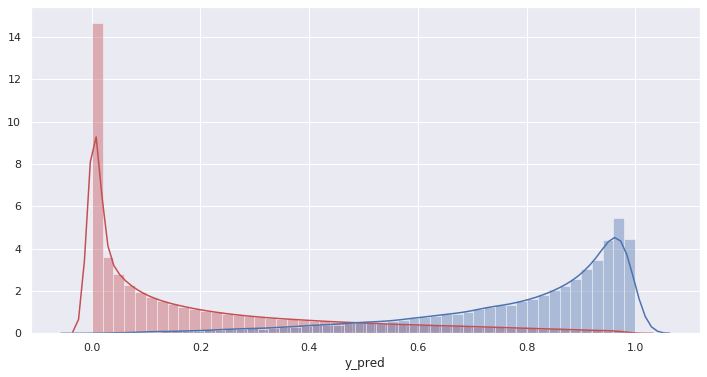

In [51]:
show_pred_dist_plot(df_result)

In [54]:
def show_precision_recall_curve(df_result):
    sns.set(rc={'figure.figsize': (12,6)})

    precision, recall, _ = precision_recall_curve(df_result.y_true, df_result.y_pred)
    average_precision = average_precision_score(df_result.y_true, df_result.y_pred)

    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.xlim([0.0, 1.0])
    plt.title('precision-recall curve: AP={0:0.2f}'.format(average_precision))
    
    plt.show()

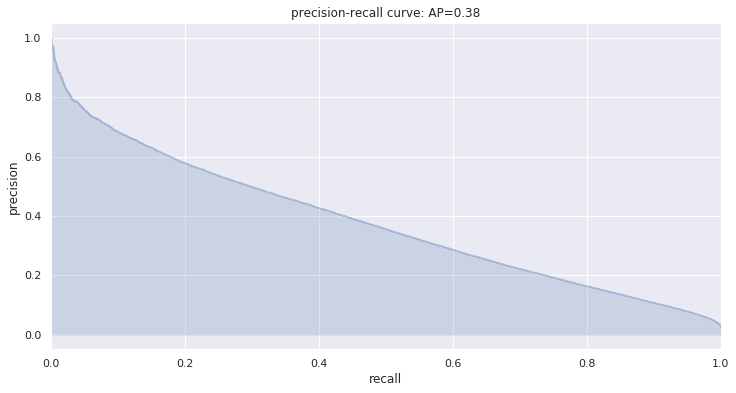

In [55]:
show_precision_recall_curve(df_result)

### modeling, evaluation 2 -> metric 변환

In [66]:
lgb_trn = lgb.Dataset(sample_x_trn, sample_y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(sample_x_val, sample_y_val, feature_name=feature_cols)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss', # auc, xentropy, binary_logloss
    'is_unbalance': True,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 30,
}

In [67]:
evals_result = {}
clf = lgb.train(params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=1000,
                early_stopping_rounds=100,
                verbose_eval=50)

Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.453833	valid_1's binary_logloss: 0.453923
[100]	training's binary_logloss: 0.424981	valid_1's binary_logloss: 0.425349
[150]	training's binary_logloss: 0.398548	valid_1's binary_logloss: 0.399048
[200]	training's binary_logloss: 0.377863	valid_1's binary_logloss: 0.378331
[250]	training's binary_logloss: 0.364712	valid_1's binary_logloss: 0.365275
[300]	training's binary_logloss: 0.355566	valid_1's binary_logloss: 0.356264
[350]	training's binary_logloss: 0.346776	valid_1's binary_logloss: 0.347661
[400]	training's binary_logloss: 0.338563	valid_1's binary_logloss: 0.339613
[450]	training's binary_logloss: 0.333063	valid_1's binary_logloss: 0.334285
[500]	training's binary_logloss: 0.326507	valid_1's binary_logloss: 0.327914
[550]	training's binary_logloss: 0.322702	valid_1's binary_logloss: 0.324307
[600]	training's binary_logloss: 0.319055	valid_1's binary_logloss: 0.320883
[650]	training

In [69]:
df_result, df_metrics, df_confusion_matrix = evaluate(sample_y_val.label.values, clf.predict(sample_x_val), cutoff=0.6)

acc    recall  precision  f1_score       auc
0  0.89444  0.832096   0.641284  0.724334  0.950391

pred: 1  pred: 0
true: 1    55936    11287
true: 0    31289   304824

In [ ]:
	acc	recall	precision	f1_score	auc
0	0.868053	0.894114	0.565928	0.693137	0.950391
pred: 1	pred: 0
true: 1	60105	7118
true: 0	46101	290012

In [ ]:
	acc	recall	precision	f1_score	auc
0	0.863047	0.896836	0.109374	0.194971	0.950933
pred: 1	pred: 0
true: 1	60288	6935
true: 0	490921	307709

## No sampling

In [40]:
idx_dev = df_dev[[idx_col]]
x_dev = df_dev[feature_cols]
y_dev = df_dev[[target_col]]

x_trn, x_val, y_trn, y_val = train_test_split(x_dev, y_dev, stratify=y_dev, test_size=0.2, random_state=23)

x_trn.shape, x_val.shape, y_trn.shape, y_val.shape

((14540972, 79), (3635243, 79), (14540972, 1), (3635243, 1))

In [41]:
y_trn.label.sum()/y_trn.shape[0], y_val.label.sum()/y_val.shape[0]

(0.0184918862370411, 0.018492023779428227)

In [42]:
lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 30,
}

In [43]:
evals_result = {}
clf = lgb.train(params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=1000,
                early_stopping_rounds=100,
                verbose_eval=50)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.881167	valid_1's auc: 0.879787
[100]	training's auc: 0.902712	valid_1's auc: 0.901438
[150]	training's auc: 0.915488	valid_1's auc: 0.914253
[200]	training's auc: 0.923919	valid_1's auc: 0.922668
[250]	training's auc: 0.929506	valid_1's auc: 0.928236
[300]	training's auc: 0.933084	valid_1's auc: 0.931761
[350]	training's auc: 0.936234	valid_1's auc: 0.934858
[400]	training's auc: 0.938834	valid_1's auc: 0.937393
[450]	training's auc: 0.94099	valid_1's auc: 0.939485
[500]	training's auc: 0.942647	valid_1's auc: 0.941043
[550]	training's auc: 0.944191	valid_1's auc: 0.942514
[600]	training's auc: 0.945579	valid_1's auc: 0.943807
[650]	training's auc: 0.94673	valid_1's auc: 0.944875
[700]	training's auc: 0.947972	valid_1's auc: 0.946015
[750]	training's auc: 0.949464	valid_1's auc: 0.947457
[800]	training's auc: 0.950216	valid_1's auc: 0.948085
[850]	training's auc: 0.950943	valid_1's auc: 0.948702
[900]

In [45]:
df_result, df_metrics, df_confusion_matrix = evaluate(y_val.label.values, clf.predict(x_val))

acc    recall  precision  f1_score       auc
0  0.863047  0.896836   0.109374  0.194971  0.950933

pred: 1  pred: 0
true: 1    60288     6935
true: 0   490921  3077099

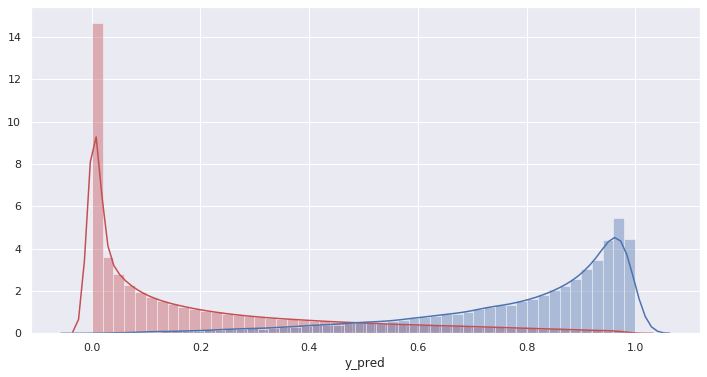

In [46]:
sns.set(rc={'figure.figsize': (12,6)})

sns.distplot(df_result[df_result.y_true==0].y_pred, norm_hist=True, color='r', label='true: 0')
sns.distplot(df_result[df_result.y_true==1].y_pred, norm_hist=True, label='true: 1')

Text(0.5, 1.0, 'precision-recall curve: AP=0.38')

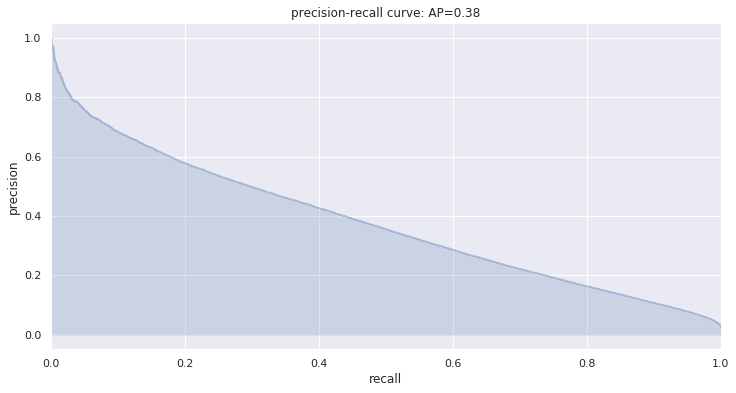

In [47]:
sns.set(rc={'figure.figsize': (12,6)})

precision, recall, _ = precision_recall_curve(df_result.y_true, df_result.y_pred)
average_precision = average_precision_score(df_result.y_true, df_result.y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim([0.0, 1.0])
plt.title('precision-recall curve: AP={0:0.2f}'.format(average_precision))

## 살펴볼 것

- 주요 evaluation metrics
    - acc, precision, recall, cf, auc
- prediction prob 분포
- 주요 feature의 label 별 분포
- 주요 feature의 FP, FN
- FP, FN shap value

